In [5]:
import numpy as np
import random
from math import *
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

### Stochastic Gradient Langevin Dynamics adapted for Mixture of two gaussian

In [6]:
def mini_batch(Num_sample,batch_size):
  '''
  Inputs:
    Num_sample: number of total samples
    batch_size: the length of the mini_batch
  ------------------------------------------------
  outputs:
    list_mini_batch: list containing mini_batches' lists
  '''
  L=list(np.arange(Num_sample))
  list_mini_batch=[]
  while len(L)>batch_size:  
    batch=list(np.random.choice(L, batch_size, replace=False))
    list_mini_batch.append(batch)
    res = [i for i in L if i not in batch]
    L=res
  if L!=[]:
    list_mini_batch.append(L)
  return(list_mini_batch)


def N(x,theta,sigma2):
  return(np.exp(-0.5*(x-theta)**2/sigma2))


def prior_grad(theta):
  '''
  This function computes the gradient of the prior funtion at theta
  '''
  return(np.array([-(theta[i])/sigma2[i] for i in range(2)]))



def lk_hood_grad(x,theta):
  '''
  This function computes the gradient of the likelihood of x for the parameter theta
  '''
  a=N(x,theta[0],sigmax2)
  b=N(x,theta[0]+theta[1],sigmax2)
  denom=a+b + 0.00001
  num_theta1=((x-theta[0])/sigmax2)*a + ((x-theta[0]- theta[1])/sigmax2)*b
  num_theta2= ((x-theta[0]- theta[1])/sigmax2)*b
  res=np.array([num_theta1/denom,num_theta2/denom])
  return(res)

def step_update(theta,mini_batch,data):
    likelihood_grad=sum([lk_hood_grad(data[i],theta) for i in mini_batch])*(len(data)/len(mini_batch))
    new_step=prior_grad(theta) + likelihood_grad
    return(new_step)
def eps_t(t):
  ''' 
  this function computes the value of the rate epsilon at instant t
  '''
  return(a/((b+t)**(gamma)))

def Stoc_lang_grad(data,batch_size,len_feature,num_repet,num_run):
  '''
  This function applies the Stochastic Gradient Langevin Dynamics
  ----------------------------------------------------------------
  inputs:
   data:
   batch size: integer
   num_repet: number of sweeps through the whole data
   num_run: number of run 
   len_feature: the legth of the learned vector
  ----------------------------------------------------------------
  outputs: list of the learned vector during iterations

  '''
  Num_sample=len(data)
  theta_final_list=[]
  delta_theta_noise_final=[]
  inject_noise_final=[]
  for run in tqdm(range(num_run)):
    list_mini_batch=mini_batch(Num_sample,batch_size)
    j=0
    theta_list=[np.random.rand(len_feature)]
    delta_theta_noise=[]
    inject_noise=[]
    for i in range(1,num_repet* len(list_mini_batch)+1):
      step=step_update(theta_list[-1],list_mini_batch[j],data)
      noise=np.random.normal(0,sqrt(eps_t(i)),size=len_feature)
      theta= theta_list[-1] + (0.5*eps_t(i)*step + noise )
      delta_theta_noise.append(0.5*eps_t(i)*step)
      inject_noise.append(eps_t(i))
      if j< (len(list_mini_batch)-1):
        j+=1
      else:
        j=0
      theta_list.append(theta)
    theta_final_list.append(theta_list)
    delta_theta_noise_final.append(delta_theta_noise)
    inject_noise_final.append(inject_noise)
  return(np.sum(theta_final_list,axis=0)/num_run,delta_theta_noise_final,inject_noise_final )

### Data Generating

In [7]:
# Data
Num_sample=100

#the prior parameters
sigma2=np.array([10,1])# this sigma2 is for the prior: theta1~N(0,sqrt(sigma2[0]) theta2~N(0,sqrt(sigma2[1])

# the likelihood is a misxture of gaussian i.e a data x s.t x~0.5*N(theta1,sqrt(sigmax2)) + 0.5*N(theta1+theta2,sqrt(sigmax2))
theta1=0
theta2=1
sigmax2=2
data=[0.5*np.random.normal(theta1,sqrt(sigmax2)) + 0.5*np.random.normal(theta1+theta2,sqrt(sigmax2)) for i in range(Num_sample)]

### learning

In [8]:
#parameter of the learning rate
a=0.19 #0.05
b=230 #10
gamma=0.55

#hyperparameters of learning
batch_size=10
num_run=10
num_repet=1000
len_feature=2 # the length of the learned vector


#list of the learned vector during the learning
Theta_vec,theta_noise,inject_noise=Stoc_lang_grad(data,batch_size,len_feature,num_repet,num_run)

  0%|          | 0/10 [00:00<?, ?it/s]

### The Noise varaince through iteration

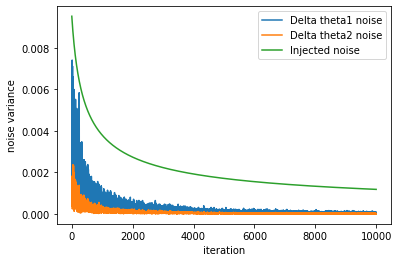

In [10]:
var_noise=np.var(np.array(theta_noise),axis=0)
var_inject_noise=np.mean(inject_noise,axis=0)
noise_theta1=var_noise[:,0]
noise_theta2=var_noise[:,1]
plt.plot(np.arange(len(noise_theta1)),noise_theta1,label='Delta theta1 noise')
plt.plot(np.arange(len(noise_theta2)),noise_theta2,label='Delta theta2 noise')
plt.plot(np.arange(len(var_inject_noise)),var_inject_noise,label='Injected noise')
plt.xlabel('iteration')
plt.ylabel('noise variance')
plt.legend()
plt.show()

### The posteriori distribution

In [11]:
### Posterior distribution of theta1, theta2
def posterior(theta1, theta2): 
    pi = N(theta1,0,sigma2[0]) * N(theta1,0,sigma2[1])
    pi =1
    for i in range(len(data)):
     
      pi*= 0.5*N(data[i],theta1,sigmax2) + 0.5*N(data[i],theta1+theta2,sigmax2)
    return pi

Text(0.5, 1.0, 'Estimated posteriori distribution')

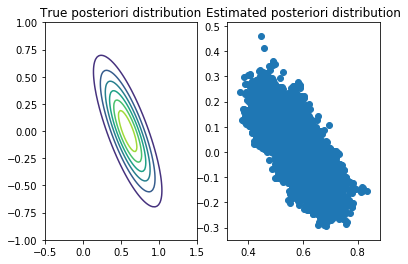

In [23]:
theta1 = np.linspace(-0.5, 1.5, 100)
theta2 = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(theta1, theta2)
Z = posterior(X, Y)


fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.contour(X, Y, Z)
ax1.set_title('True posteriori distribution')
ax2.scatter(Theta_vec[:,0],Theta_vec[:,1])
ax2.set_title('Estimated posteriori distribution')


